<a href="https://colab.research.google.com/github/fco-parga/mna-navegacion_autonoma/blob/main/Actividad-4.1/Actividad_4_1_Ejercicio_de_clasificacion_con_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

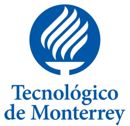

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Navegación autónoma**
### Tecnológico de Monterrey
###  	Dr. David Antonio Torres

#### **Actividad 4.1 - Detección de Peatones con Keras**
____


**Nombres y matrículas de los integrantes del equipo:**

*   Julio Cesar Lynn Jimenez A01793660
*   Francisco Javier Parga García A01794380
*   Carlos Roberto Torres Ferguson A01215432
*   Fernando Sebastian Sanchez Cardona A01687530

____

### Ajustes para correr en Google-Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Libreria para manipular variables de sistema
import os

# Seteo del folder de inters
os.chdir("/content/drive/MyDrive/Colab Notebooks/MNA/03_2023-Abril-Julio/Navegacion_Autonoma/03_Deteccion_de_Peatones_Keras")

In [3]:
!ls -lart ../02_Deteccion_de_Peatones/data/

total 1315331
-rw------- 1 root root 1278503356 May 21 10:49 INRIAPerson.zip
drwx------ 4 root root       4096 May 21 12:07 INRIAPerson
-rw------- 1 root root   68390816 May 21 13:01 video_2_2.mp4


# 0. Librerias requerias

In [4]:
# Instalar bibliotecas requeridas
!pip install -q scikit-image
!pip install -q seaborn
!pip install -q opencv-python

In [5]:
# Cargar librerias

import os
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (5,3)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Deteccion de peatones con Keras

## Generadores de datos

In [7]:
# Aumento de datos con generador de imagenes
# Data augmentation with image generator

# crea un generador de datos de imágenes para los datos de entrenamiento
# aplica algunas transformaciones para aumentar la diversidad de los datos
train_datagen = ImageDataGenerator(
    rescale=1./255, # normaliza los valores de los píxeles
    shear_range=0.2, # aplica transformaciones de corte aleatorias
    zoom_range=0.2, # aplica transformaciones de zoom aleatorias
    horizontal_flip=True, # voltea las imágenes horizontalmente de forma aleatoria
    validation_split=0.2 # establece el porcentaje de validación
)

# define un generador de datos de imágenes para los datos de validación y prueba
# solo aplica el reescalado para normalizar los valores de los píxeles
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# especifica el tamaño de la imagen y el tamaño del lote
img_size = (100, 100) # tamaño reducido para menos carga computacional
batch_size = 32 # número de imágenes por lote 

In [8]:
data_path = "../02_Deteccion_de_Peatones/data/"

# Generador para el set de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_path+"INRIAPerson/Train/",
    target_size=img_size,
    batch_size=batch_size,
    classes=['pos', 'neg'], 
    class_mode='categorical',
    subset='training'
)

# Generador para el set de validacion
validation_generator = train_datagen.flow_from_directory(
    data_path+"INRIAPerson/Test/",
    target_size=img_size,
    batch_size=batch_size,
    classes=['pos', 'neg'], 
    class_mode='categorical',
    subset='validation'
)


Found 1467 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


## Modelo CNN Keras

In [10]:
with tf.device('/gpu:0'): # forzando a TensorFlow a usar la GPU (si está disponible)
    # Define la arquitectura del modelo
    model = Sequential()
    model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(img_size[0], img_size[1], 3))) # añade una capa de convolución con 32 filtros de 3x3 y función de activación relu
    model.add(MaxPooling2D(pool_size=(2, 2))) # añade una capa de agrupación máxima con un tamaño de ventana de 2x2
    model.add(Conv2D(64, (3, 3), activation='relu')) # añade otra capa de convolución con 64 filtros de 3x3 y función de activación relu
    model.add(MaxPooling2D(pool_size=(2, 2))) # añade otra capa de agrupación máxima con un tamaño de ventana de 2x2
    model.add(Conv2D(128, (4, 4), activation='relu')) # añade otra capa de convolución con 128 filtros de 3x3 y función de activación relu
    model.add(MaxPooling2D(pool_size=(2, 2))) # añade otra capa de agrupación máxima con un tamaño de ventana de 2x2
    model.add(Flatten()) # aplana la salida de la última capa de convolución para pasarla a la capa densa
    model.add(Dense(128, activation='relu', kernel_regularizer='l2')) # añade una capa densa con 128 unidades y función de activación relu y regularización l2
    model.add(Dropout(0.5)) # añade una capa de abandono con una tasa de 0.5 para reducir el sobreajuste
    model.add(Dense(64, activation='relu', kernel_regularizer='l2')) # añade una capa densa con 64 unidades y función de activación relu y regularización l2
    model.add(Dropout(0.5)) # añade una capa de abandono con una tasa de 0.5 para reducir el sobreajuste
    model.add(Dense(16, activation='relu', kernel_regularizer='l2')) # añade una capa densa con 16 unidades y función de activación relu y regularización l2
    model.add(Dropout(0.5)) # añade una capa de abandono con una tasa de 0.5 para reducir el sobreajuste
    model.add(Dense(2, activation='softmax')) # softmax para devolver la probabilidad en cada clase

    # Compila el modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Parada temprana
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=17) # define un criterio para detener el entrenamiento si la pérdida de validación no mejora después de 7 épocas

    # Punto de control del modelo
    model_checkpoint = ModelCheckpoint('keras_cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) # define un criterio para guardar el mejor modelo según la precisión de validación


In [11]:
#Visualizar el resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 99, 99, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)     

In [12]:
%%time

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=101, 
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/101
46/46 [==============================] - ETA: 0s - loss: 1.9895 - accuracy: 0.6353
Epoch 1: val_accuracy improved from -inf to 0.61224, saving model to keras_cnn_best_model.h5
46/46 [==============================] - 31s 602ms/step - loss: 1.9895 - accuracy: 0.6353 - val_loss: 1.2967 - val_accuracy: 0.6122
Epoch 2/101
46/46 [==============================] - ETA: 0s - loss: 1.1049 - accuracy: 0.6694
Epoch 2: val_accuracy improved from 0.61224 to 0.63946, saving model to keras_cnn_best_model.h5
46/46 [==============================] - 27s 582ms/step - loss: 1.1049 - accuracy: 0.6694 - val_loss: 0.9038 - val_accuracy: 0.6395
Epoch 3/101
46/46 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.7130
Epoch 3: val_accuracy improved from 0.63946 to 0.83673, saving model to keras_cnn_best_model.h5
46/46 [==============================] - 31s 672ms/step - loss: 0.8868 - accuracy: 0.7130 - val_loss: 0.7131 - val_accuracy: 0.8367
Epoch 4/101
46/46 [===============

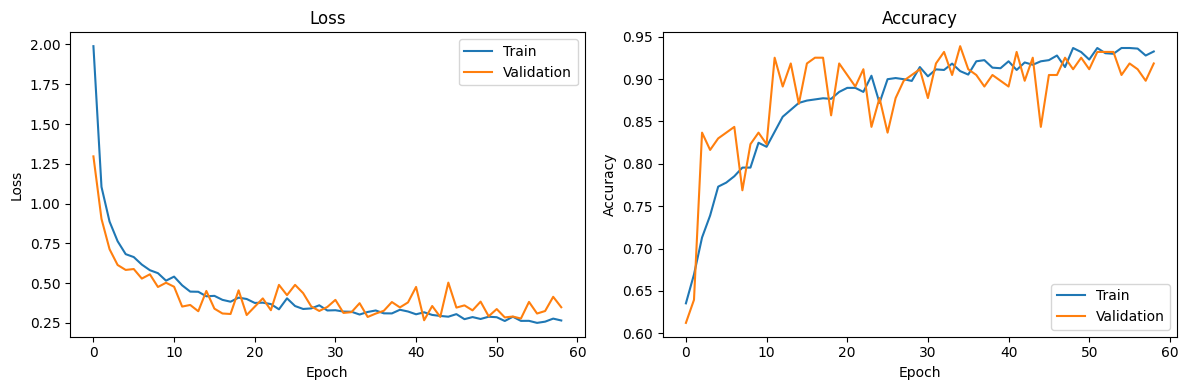

In [13]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [14]:
labels = []
for val in range(len(validation_generator)):
  labels.append(validation_generator[val][1].tolist())

y_test = np.array([x for x in labels for x in x])
y_test = np.argmax(y_test, axis=1)

y_test.shape

(147,)

In [15]:
y_predict = model.predict(validation_generator)

y_predict = np.argmax(y_predict, axis=1)

5/5 [==============================] - 4s 700ms/step


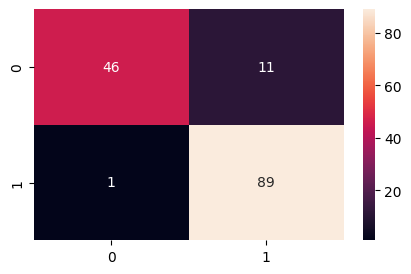

In [16]:
# Importar las bibliotecas para las métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d");

In [17]:
# Imprimir el informe de clasificación
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88        57
           1       0.89      0.99      0.94        90

    accuracy                           0.92       147
   macro avg       0.93      0.90      0.91       147
weighted avg       0.92      0.92      0.92       147



# Detector de peatones con Keras

In [26]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
from PIL import Image
import tensorflow as tf

class PedestrianDetector:
    def __init__(self, model):
        self.model = model

    def process_frame(self, img):
        # Define parameters for sliding window
        window_size = (200, 200)  # Size of the sliding window
        step_size = 32  # Step size of the sliding window

        # Calculate the starting y-coordinate for the sliding window
        start_y = img.shape[0] // 2 - 50
        end_y = int(img.shape[0] * 0.7)

        # Define a function to resize and normalize an image
        def preprocess_image(image):
            image = tf.image.resize(image, (100, 100))
            image = tf.cast(image, tf.float32)
            image = (image - 127.5) / 127.5
            return image

        # Slide the window over the image
        for y in range(start_y, end_y, step_size):
            for x in range(0, img.shape[1], step_size):
                # Extract the region of interest
                roi = img[y:y + window_size[1], x:x + window_size[0]]

                # Skip if the region of interest is not the same size as the window
                if roi.shape[0] != window_size[1] or roi.shape[1] != window_size[0]:
                    continue
                roi_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

                # Convert the region of interest to a TensorFlow tensor and normalize
                roi_tensor = preprocess_image(roi_pil)
                roi_tensor = tf.expand_dims(roi_tensor, axis=0)

                # Predict whether the region of interest contains a pedestrian
                self.outputs = self.model(roi_tensor)
                self.probabilities = tf.nn.softmax(self.outputs)
                
                # If a pedestrian is detected, draw a rectangle around the region of interest
                if self.probabilities[0][1] > 0.9:
                    cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
                    print('Pedestrian')


        return img

    def process_video(self, input_video_path, output_video_path, fracction_to_process=0.1):
        cap = cv2.VideoCapture(input_video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the number of frames to process (100% of total frames)
        num_frames_to_process = int(total_frames * fracction_to_process)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        pbar = tqdm(total=num_frames_to_process, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}',
                    position=0, leave=True)

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                result_frame = self.process_frame(frame)
                out.write(result_frame)
                #cv2.imshow('Processed Frame', result_frame)

                pbar.update(1)
                frame_count += 1

                if frame_count >= num_frames_to_process:
                    break

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break

        pbar.close()

        cap.release()
        out.release()
        cv2.destroyAllWindows()

In [27]:
# Definir las rutas de los archivos de vídeo de entrada y salida
input_video_path = data_path+'video_2_2.mp4'
output_video_path = 'video_2_2_process_cnn-Keras.mp4'

In [28]:
%%time
# Crear una instancia de PedestrianDetector con svc_model como el modelo a usar
pedestrian_detector = PedestrianDetector(model)

# Procesar el archivo de vídeo de entrada y guardar el archivo de vídeo de salida usando el método process_video
pedestrian_detector.process_video(input_video_path, output_video_path, fracction_to_process=0.05)

100%|██████████████████████████████████████████████████████████████████| 183/183

CPU times: user 2min 9s, sys: 2.12 s, total: 2min 11s
Wall time: 2min 17s
